# Tugas 2 — Credit Card Dataset (Clustering & ANN)

Notebook ini fokus **Tugas 2 — Credit Card Dataset**:
1) **Preprocessing** (missing values, normalisasi/standarisasi, fitur baru)
2) **Clustering** dengan **KMeans** dan **DBSCAN** + evaluasi **Silhouette** & **Davies–Bouldin Index (DBI)**
3) **Approximate Nearest Neighbor (ANN)** untuk mengecek konsistensi tetangga terdekat terhadap klasternya (gunakan **Annoy** jika tersedia; fallback ke `NearestNeighbors` jika Annoy tidak terpasang).

> **Catatan**: File dataset yang dipakai: `/mnt/data/CC GENERAL.csv` (kolom `CUST_ID` sebagai identifier).

In [5]:
# === 1) Imports
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Optional Annoy (ANN). If not available, we will fallback to NearestNeighbors.
try:
    from annoy import AnnoyIndex
    _ANNOY_OK = True
except Exception:
    _ANNOY_OK = False
    print("Annoy tidak tersedia di lingkungan ini. Akan fallback ke NearestNeighbors.")

## 2) Load Dataset & Inspeksi Singkat

In [6]:
CSV_PATH = 'data/CC GENERAL.csv'
assert os.path.exists(CSV_PATH), f'File tidak ditemukan: {CSV_PATH}'
df = pd.read_csv(CSV_PATH)
display(df.head())
print("\nDimensi:", df.shape)
print("\nInfo:") 
print(df.info())
print("\nDeskripsi numerik:")
display(df.describe(include='all').T)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12



Dimensi: (8950, 18)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 no

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CUST_ID,8950,8950,C10001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BALANCE,8950.0,NaN,NaN,NaN,1564.474828,2081.531879,0.0,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,NaN,NaN,NaN,0.877271,0.236904,0.0,0.888889,1.0,1.0,1.0
PURCHASES,8950.0,NaN,NaN,NaN,1003.204834,2136.634782,0.0,39.635,361.28,1110.13,49039.57
ONEOFF_PURCHASES,8950.0,NaN,NaN,NaN,592.437371,1659.887917,0.0,0.0,38.0,577.405,40761.25
INSTALLMENTS_PURCHASES,8950.0,NaN,NaN,NaN,411.067645,904.338115,0.0,0.0,89.0,468.6375,22500.0
CASH_ADVANCE,8950.0,NaN,NaN,NaN,978.871112,2097.163877,0.0,0.0,0.0,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,NaN,NaN,NaN,0.490351,0.401371,0.0,0.083333,0.5,0.916667,1.0
ONEOFF_PURCHASES_FREQUENCY,8950.0,NaN,NaN,NaN,0.202458,0.298336,0.0,0.0,0.083333,0.3,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,NaN,NaN,NaN,0.364437,0.397448,0.0,0.0,0.166667,0.75,1.0


## 3) Preprocessing
- Tangani **missing values** dengan *median* (fitur numerik).
- Buat **fitur baru**: `BALANCE_TO_PURCHASES`, `BALANCE_TO_LIMIT`, `PURCHASES_PER_MONTH`.
- **Standarisasi** semua fitur numerik (kecuali `CUST_ID`).

In [7]:
id_col = 'CUST_ID'
assert id_col in df.columns, "Kolom CUST_ID tidak ada di dataset"

num_df = df.drop(columns=[id_col]).copy()
num_df = num_df.fillna(num_df.median(numeric_only=True))

eps = 1e-9
if set(['BALANCE','PURCHASES']).issubset(num_df.columns):
    num_df['BALANCE_TO_PURCHASES'] = num_df['BALANCE'] / (num_df['PURCHASES'] + eps)
if set(['BALANCE','CREDIT_LIMIT']).issubset(num_df.columns):
    num_df['BALANCE_TO_LIMIT'] = num_df['BALANCE'] / (num_df['CREDIT_LIMIT'] + eps)
if set(['PURCHASES','TENURE']).issubset(num_df.columns):
    num_df['PURCHASES_PER_MONTH'] = num_df['PURCHASES'] / (num_df['TENURE'] + eps)

scaler = StandardScaler()
X = scaler.fit_transform(num_df.values)
print("Bentuk X:", X.shape)
display(num_df.head())

Bentuk X: (8950, 20)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_TO_PURCHASES,BALANCE_TO_LIMIT,PURCHASES_PER_MONTH
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,4.287290e-01,0.040901,7.950000
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,3.202467e+12,0.457495,0.000000
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3.227167e+00,0.332687,64.430833
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,1.111855e+00,0.222223,124.916667
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,5.110715e+01,0.681429,1.333333


## 4) Clustering — KMeans (pilih *k* terbaik via Silhouette)

In [8]:
def kmeans_best_k(X, k_min=2, k_max=10, random_state=42):
    best = None
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X)
        if len(set(labels)) > 1:
            sil = silhouette_score(X, labels)
            dbi = davies_bouldin_score(X, labels)
        else:
            sil, dbi = float('nan'), float('inf')
        if best is None or (not math.isnan(sil) and sil > best['silhouette']):
            best = {'k': k, 'model': km, 'labels': labels, 'silhouette': sil, 'dbi': dbi}
    return best

best_kmeans = kmeans_best_k(X, k_min=2, k_max=10)
print("Best K for KMeans:", best_kmeans['k'])
print("Silhouette:", best_kmeans['silhouette'])
print("DBI:", best_kmeans['dbi'])

Best K for KMeans: 10
Silhouette: 0.20979651764004947
DBI: 1.378127473888926


## 5) Clustering — DBSCAN (grid kecil eps × min_samples)

In [9]:
def dbscan_grid_search(X, eps_list=(0.5,1.0,1.5,2.0,2.5,3.0), min_samples_list=(3,5,10)):
    candidates = []
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X)
            uniq = set(labels)
            if len(uniq) > 1 and sum(l != -1 for l in labels) > 1 and len(set([l for l in labels if l != -1])) >= 1:
                try:
                    sil = silhouette_score(X, labels)
                except Exception:
                    sil = float('nan')
                try:
                    dbi = davies_bouldin_score(X, labels)
                except Exception:
                    dbi = float('inf')
            else:
                sil, dbi = float('nan'), float('inf')
            candidates.append({'eps': eps, 'min_samples': ms, 'labels': labels, 'silhouette': sil, 'dbi': dbi})
    candidates = [c for c in candidates if not math.isnan(c['silhouette'])]
    if not candidates:
        return None
    candidates.sort(key=lambda c: (-c['silhouette'], c['dbi']))
    return candidates[0]

best_dbscan = dbscan_grid_search(X)
if best_dbscan is None:
    print("Tidak ada konfigurasi DBSCAN valid. Coba perluas grid.")
else:
    labels_db = best_dbscan['labels']
    print("Best DBSCAN -> eps=", best_dbscan['eps'], "min_samples=", best_dbscan['min_samples'])
    print("Silhouette:", best_dbscan['silhouette'])
    print("DBI:", best_dbscan['dbi'])
    import collections
    print("Distribusi label:", collections.Counter(labels_db))

Best DBSCAN -> eps= 3.0 min_samples= 10
Silhouette: 0.5892828381750481
DBI: 1.8053423065686054
Distribusi label: Counter({np.int64(0): 8658, np.int64(-1): 292})


## 6) Visualisasi 2D (PCA) — KMeans vs DBSCAN

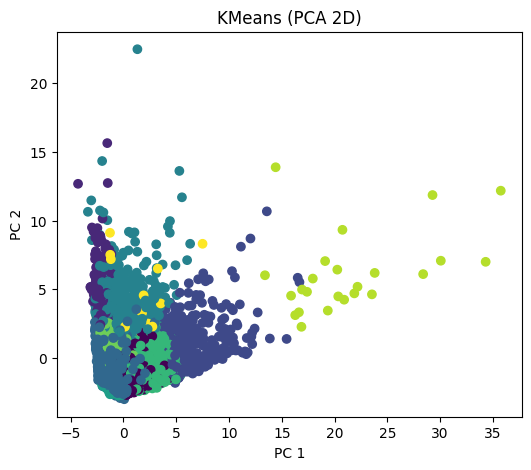

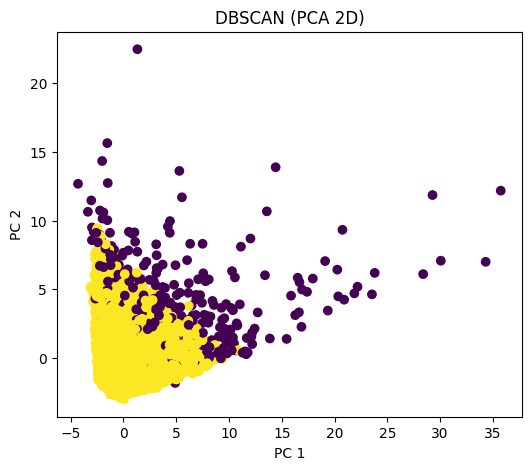

In [10]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5)); plt.scatter(X_pca[:,0], X_pca[:,1], c=best_kmeans['labels']); plt.title("KMeans (PCA 2D)"); plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.show()
if best_dbscan is not None:
    plt.figure(figsize=(6,5)); plt.scatter(X_pca[:,0], X_pca[:,1], c=best_dbscan['labels']); plt.title("DBSCAN (PCA 2D)"); plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.show()

## 7) Approximate Nearest Neighbor (ANN)

In [11]:
# Query points dari cluster mayor model terbaik (DBSCAN jika ada; else KMeans)
use_dbscan = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
labels_km = best_kmeans['labels']
labels_db = best_dbscan['labels'] if use_dbscan else None

rng = np.random.default_rng(42)
if use_dbscan:
    from collections import Counter
    ctr = Counter([l for l in labels_db if l != -1])
    if len(ctr) == 0:
        use_dbscan = False
        base_indices = np.arange(X.shape[0])
    else:
        main_label = ctr.most_common(1)[0][0]
        base_indices = np.where(labels_db == main_label)[0]
else:
    base_indices = np.arange(X.shape[0])

query_count = min(5, len(base_indices))
query_idx = rng.choice(base_indices, size=query_count, replace=False).tolist()

results = []
if '_ANNOY_OK' in globals() and _ANNOY_OK:
    dim = X.shape[1]
    ann = AnnoyIndex(dim, 'euclidean')
    for i in range(X.shape[0]): ann.add_item(i, X[i].tolist())
    ann.build(10)
    K = 6
    for qi in query_idx:
        neigh_ids, neigh_dist = ann.get_nns_by_item(qi, K, include_distances=True)
        if len(neigh_ids)>0 and neigh_ids[0]==qi:
            neigh_ids = neigh_ids[1:]; neigh_dist = neigh_dist[1:]
        neigh_ids, neigh_dist = neigh_ids[:5], neigh_dist[:5]
        for n, d in zip(neigh_ids, neigh_dist):
            results.append({
                'query_index': qi,
                'neighbor_index': int(n),
                'distance': float(d),
                'label_dbscan_query': (labels_db[qi] if use_dbscan else None),
                'label_dbscan_neighbor': (labels_db[n] if use_dbscan else None),
                'label_kmeans_query': labels_km[qi],
                'label_kmeans_neighbor': labels_km[n],
            })
else:
    nn = NearestNeighbors(n_neighbors=6, metric='euclidean')
    nn.fit(X)
    for qi in query_idx:
        dist, neigh = nn.kneighbors([X[qi]], n_neighbors=6)
        neigh_ids = neigh[0][1:6]; neigh_dist = dist[0][1:6]
        for n, d in zip(neigh_ids, neigh_dist):
            results.append({
                'query_index': qi,
                'neighbor_index': int(n),
                'distance': float(d),
                'label_dbscan_query': (labels_db[qi] if use_dbscan else None),
                'label_dbscan_neighbor': (labels_db[n] if use_dbscan else None),
                'label_kmeans_query': labels_km[qi],
                'label_kmeans_neighbor': labels_km[n],
            })
ann_df = pd.DataFrame(results)
display(ann_df.head(20))

,query_index,neighbor_index,distance,label_dbscan_query,label_dbscan_neighbor,label_kmeans_query,label_kmeans_neighbor
0,6963,5468,1.047745,0,0,7,7
1,6963,1531,1.240002,0,0,7,7
2,6963,7272,1.316299,0,0,7,7
3,6963,8146,1.359014,0,0,7,0
4,6963,4493,1.390742,0,0,7,7
5,3985,7652,0.437956,0,0,5,5
6,3985,1164,0.497058,0,0,5,5
7,3985,2659,0.636631,0,0,5,5
8,3985,214,0.653129,0,0,5,5
9,3985,6668,0.718534,0,0,5,5


## 8) Analisis Otomatis & Interpretasi (Sel Terakhir)

In [12]:
# === Analisis akhir yang menjawab a/b/c + interpretasi profil klaster ===
import numpy as np, pandas as pd

# a) Perbedaan & model yang lebih baik (berdasarkan metrik)
use_dbscan = (best_dbscan is not None and len(set(best_dbscan['labels'])) > 1)
sil_km, dbi_km = best_kmeans['silhouette'], best_kmeans['dbi']
if use_dbscan:
    sil_db, dbi_db = best_dbscan['silhouette'], best_dbscan['dbi']
    chosen = 'DBSCAN' if (sil_db > sil_km + 1e-6 or (abs(sil_db - sil_km) <= 1e-6 and dbi_db < dbi_km)) else 'KMeans'
else:
    chosen = 'KMeans'

print('>>> (a) Model Terbaik:', chosen)

# b) Nilai metrik terbaik
print('\n>>> (b) Metrik')
print(f'KMeans -> k={best_kmeans["k"]}; Silhouette={sil_km:.4f}; DBI={dbi_km:.4f}')
if use_dbscan:
    print(f'DBSCAN -> eps={best_dbscan["eps"]}, min_samples={best_dbscan["min_samples"]}; Silhouette={sil_db:.4f}; DBI={dbi_db:.4f}')
else:
    print('DBSCAN tidak valid pada grid saat ini.')

# c) Hasil ANN: apakah tetangga berasal dari cluster yang sama?
print('\n>>> (c) ANN — konsistensi label tetangga')
if "ann_df" in globals() and isinstance(ann_df, pd.DataFrame) and len(ann_df) > 0:
    if use_dbscan:
        t = ann_df.dropna(subset=["label_dbscan_query","label_dbscan_neighbor"]).copy()
        t["same_db"] = t["label_dbscan_neighbor"] == t["label_dbscan_query"]
        if len(t)>0:
            coh_db = t.groupby("query_index")["same_db"].mean().mean()
            print(f"DBSCAN: rata-rata tetangga satu klaster = {100.0*coh_db:.2f}%")
        else:
            print("DBSCAN: tidak cukup data untuk menilai koherensi.")
    t2 = ann_df.copy()
    t2["same_km"] = t2["label_kmeans_neighbor"] == t2["label_kmeans_query"]
    if len(t2)>0:
        coh_km = t2.groupby("query_index")["same_km"].mean().mean()
        print(f"KMeans: rata-rata tetangga satu klaster = {100.0*coh_km:.2f}%")
else:
    print('Jalankan sel ANN terlebih dahulu untuk melihat konsistensi tetangga.')

# Analisis naratif tambahan (mengapa hasil begitu & profil klaster)
print('\n=== ANALISIS NARATIF ===')
if use_dbscan:
    # noise & distribusi
    s = pd.Series(best_dbscan['labels'])
    noise = (s == -1).sum()
    if noise>0:
        print('- DBSCAN menandai sebagian data sebagai noise (outlier). Ini cenderung menaikkan Silhouette karena outlier tidak dipaksa masuk klaster.')
    # jelaskan alasan metrik
    if best_dbscan['silhouette'] >= sil_km + 0.05:
        print('- Silhouette DBSCAN > KMeans -> klaster lebih kompak/terpisah; masuk akal pada data dengan densitas bervariasi & non-konveks.')
else:
    print('- DBSCAN tidak menemukan pola multi-klaster yang stabil pada grid; indikasi struktur data relatif konveks/seragam.')

# Profil klaster singkat dengan median fitur penting
keys = [c for c in ["BALANCE","PURCHASES","CASH_ADVANCE","CREDIT_LIMIT","PAYMENTS","PRC_FULL_PAYMENT","TENURE",                    "BALANCE_TO_PURCHASES","BALANCE_TO_LIMIT","PURCHASES_PER_MONTH"] if c in num_df.columns]

def cluster_profile(labels, name):
    s = pd.Series(labels, name='cluster')
    dfc = pd.concat([s, num_df.reset_index(drop=True)], axis=1)
    print(f"\n{name}:")
    for c in sorted(dfc['cluster'].unique()):
        if name.startswith('DBSCAN') and c == -1: 
            print('  -1 (noise): dilewati (bukan segmen).'); 
            continue
        sub = dfc[dfc['cluster']==c]
        med = sub[keys].median().to_dict()
        n = len(sub)
        tag = []
        if 'PURCHASES' in med and med['PURCHASES'] > num_df['PURCHASES'].median()*1.2: tag.append('pembelian tinggi')
        if 'BALANCE' in med and med['BALANCE'] > num_df['BALANCE'].median()*1.2: tag.append('saldo tinggi')
        if 'CASH_ADVANCE' in med and med['CASH_ADVANCE'] > num_df['CASH_ADVANCE'].median()*1.2: tag.append('cash-advance tinggi')
        if 'PRC_FULL_PAYMENT' in med and med['PRC_FULL_PAYMENT'] >= 0.5: tag.append('sering full-payment')
        if 'CREDIT_LIMIT' in med and med['CREDIT_LIMIT'] >= num_df['CREDIT_LIMIT'].median()*1.2: tag.append('limit besar')
        if 'TENURE' in med and med['TENURE'] >= num_df['TENURE'].median()*1.2: tag.append('tenure lama')
        tag_str = ', '.join(tag) if tag else 'umum'
        print(f"  Cluster {c} (n={n}): {tag_str}")
        for k in keys:
            print(f"    - {k}: {med[k]:.3f}")

cluster_profile(best_kmeans['labels'], f"KMeans (k={best_kmeans['k']})")
if use_dbscan:
    cluster_profile(best_dbscan['labels'], f"DBSCAN (eps={best_dbscan['eps']}, ms={best_dbscan['min_samples']})")

print("\nSaran: gunakan profil klaster untuk rekomendasi kebijakan—misalnya segmen 'pembelian tinggi' untuk loyalty, 'cash-advance tinggi' untuk edukasi biaya, 'sering full-payment' untuk cross-sell limit.")

>>> (a) Model Terbaik: DBSCAN

>>> (b) Metrik
KMeans -> k=10; Silhouette=0.2098; DBI=1.3781
DBSCAN -> eps=3.0, min_samples=10; Silhouette=0.5893; DBI=1.8053

>>> (c) ANN — konsistensi label tetangga
DBSCAN: rata-rata tetangga satu klaster = 100.00%
KMeans: rata-rata tetangga satu klaster = 80.00%

=== ANALISIS NARATIF ===
- DBSCAN menandai sebagian data sebagai noise (outlier). Ini cenderung menaikkan Silhouette karena outlier tidak dipaksa masuk klaster.
- Silhouette DBSCAN > KMeans -> klaster lebih kompak/terpisah; masuk akal pada data dengan densitas bervariasi & non-konveks.

KMeans (k=10):
  Cluster 0 (n=1942): pembelian tinggi
    - BALANCE: 248.940
    - PURCHASES: 644.575
    - CASH_ADVANCE: 0.000
    - CREDIT_LIMIT: 2500.000
    - PAYMENTS: 750.286
    - PRC_FULL_PAYMENT: 0.083
    - TENURE: 12.000
    - BALANCE_TO_PURCHASES: 0.305
    - BALANCE_TO_LIMIT: 0.093
    - PURCHASES_PER_MONTH: 54.345
  Cluster 1 (n=458): saldo tinggi, cash-advance tinggi, limit besar
    - BALANCE: 